In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install pyppeteer # use to show graph png
# !pip install graphviz # use to show graph png

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('./credential/cred.env')

# Get the API key from the environment variables
api_key = os.environ.get("API_KEY")

# Check if the API key was found
if api_key:
  print("API Key loaded successfully.")
else:
  print("API Key not found in the environment variables.")
os.environ["OPENAI_API_KEY"] = api_key

API Key loaded successfully.


# Chapter 4. Using LangGraph to Add Memory to Your Chatbot

ในบทที่ 3 คุณได้เรียนรู้วิธีการจัดหาบริบทที่ทันสมัยและเกี่ยวข้องกับแอปพลิเคชันแชทบอท AI ของคุณ ซึ่งช่วยให้แชทบอทของคุณสามารถสร้างการตอบกลับที่ถูกต้องตามอินพุตของผู้ใช้ได้ แต่เพียงเท่านี้ยังไม่เพียงพอสำหรับการสร้างแอปพลิเคชันที่พร้อมใช้งานจริง คุณจะเปิดใช้งานแอปพลิเคชันของคุณให้ "แชท" ไปกลับกับผู้ใช้ได้อย่างไร ในขณะที่จำบทสนทนาและบริบทที่เกี่ยวข้องก่อนหน้านี้

**โมเดลภาษาขนาดใหญ่ไม่มีสถานะ (stateless)**
ซึ่งหมายความว่าทุกครั้งที่มีการกระตุ้นให้โมเดลสร้างการตอบกลับใหม่ โมเดลจะไม่มีหน่วยความจำของพรอมต์หรือการตอบกลับของโมเดลก่อนหน้า เพื่อที่จะจัดหาข้อมูลประวัติศาสตร์นี้ให้กับโมเดล เราจำเป็นต้องมีระบบหน่วยความจำที่แข็งแกร่งซึ่งจะติดตามการสนทนาและบริบทก่อนหน้า ข้อมูลประวัติศาสตร์นี้สามารถรวมอยู่ในพรอมต์สุดท้ายที่ส่งไปยัง LLM ได้ ทำให้โมเดลมี "หน่วยความจำ" รูปดังกล่าว แสดงให้เห็น

<img align="top" src="./pics/Figure4-1.png"     style=" width:380px; padding: 10px; " >


---

**ในบทนี้ คุณจะได้เรียนรู้วิธีการสร้างระบบหน่วยความจำที่สำคัญนี้โดยใช้โมดูลที่มีอยู่ภายในของ LangChain เพื่อทำให้กระบวนการพัฒนาง่ายขึ้น**

# Building a Chatbot Memory System

**การสร้างระบบหน่วยความจำสำหรับแชทบอท**

มีการตัดสินใจออกแบบหลักสองประการอยู่เบื้องหลังระบบหน่วยความจำที่แข็งแกร่งทุกระบบ:

1. วิธีการจัดเก็บสถานะ
2. วิธีการค้นหาสถานะ

วิธีง่ายๆ ในการสร้างระบบหน่วยความจำสำหรับแชทบอทที่รวมโซลูชันที่มีประสิทธิภาพสำหรับการตัดสินใจออกแบบเหล่านี้คือ การจัดเก็บและนำประวัติการโต้ตอบทั้งหมดระหว่างผู้ใช้และโมเดลมาใช้ใหม่ สถานะของระบบหน่วยความจำนี้สามารถ:

จัดเก็บเป็นรายการข้อความ (ดูข้อมูลเพิ่มเติมเกี่ยวกับข้อความใน บทที่ 1)
อัปเดตโดยการเพิ่มข้อความล่าสุดหลังจากแต่ละเทิร์น
เพิ่มลงในพรอมต์โดยการแทรกข้อความลงในพรอมต์
ดังรูป แสดงให้เห็นระบบหน่วยความจำอย่างง่ายนี้

---

<img align="top" src="./pics/Figure4-2.png"     style=" width:380px; padding: 10px; " >


---

นี่คือตัวอย่างโค้ดที่แสดงให้เห็นถึงระบบหน่วยความจำในรูปแบบง่ายๆ โดยใช้ LangChain:



In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Answer all questions to the best of your ability."),
    ("placeholder", "{messages}"),
])

model = ChatOpenAI()

chain = prompt | model

chain.invoke({
    "messages": [
        ("human","Translate this sentence from English to French: I love programming."),
        ("ai", "J'adore la programmation."),
        ("human", "What did you just say?"),
    ],
})

AIMessage(content='I said "J\'adore la programmation" which means "I love programming" in French.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 61, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3c1a98f0-a073-46d7-987b-d67e1ab7b747-0', usage_metadata={'input_tokens': 61, 'output_tokens': 22, 'total_tokens': 83, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

โปรดสังเกตว่าการรวมบทสนทนาก่อนหน้านี้ในเชนช่วยให้โมเดลสามารถตอบคำถามติดตามได้อย่างเข้าใจบริบท
แม้ว่าวิธีนี้จะง่ายและใช้งานได้ แต่เมื่อนำแอปพลิเคชันของคุณไปใช้งานจริง คุณจะพบกับความท้าทายเพิ่มเติมที่เกี่ยวข้องกับการจัดการหน่วยความจำในระดับสูง เช่น:
1. คุณจะต้องอัปเดตหน่วยความจำหลังจากการโต้ตอบทุกครั้ง โดยเป็นอะตอมิก (กล่าวคือ ไม่บันทึกเฉพาะคำถามหรือคำตอบเท่านั้นในกรณีที่เกิดความล้มเหลว)
2. คุณจะต้องจัดเก็บหน่วยความจำเหล่านี้ในที่เก็บข้อมูลถาวร เช่น ฐานข้อมูลเชิงสัมพันธ์
3. คุณจะต้องควบคุมจำนวนและข้อความใดที่จะถูกจัดเก็บไว้สำหรับการโต้ตอบในภายหลัง และจำนวนข้อความเหล่านี้ที่ถูกนำมาใช้สำหรับการโต้ตอบใหม่
4. คุณจะต้องตรวจสอบและปรับเปลี่ยนสถานะนี้ (สำหรับตอนนี้ เพียงแค่รายการข้อความ) ภายนอกการเรียกใช้งาน LLM

**ตอนนี้เราจะแนะนำเครื่องมือที่ดีกว่า ซึ่งจะช่วยในเรื่องนี้และในบทต่อไปทั้งหมด**

# Introducing LangGraph


**แนะนำ LangGraph**

ตลอดช่วงที่เหลือของบทนี้และบทต่อไป เราจะเริ่มใช้ LangGraph ซึ่งเป็นไลบรารีโอเพนซอร์สที่เขียนโดย LangChain LangGraph ได้รับการออกแบบมาเพื่อให้ผู้พัฒนาสามารถใช้งานสถาปัตยกรรมความรู้แบบหลายตัวกระทำ หลายขั้นตอน และมีสถานะ ซึ่งเรียกว่า กราฟ คำศัพท์เหล่านี้บรรจุอยู่ในประโยคสั้น ๆ มาดูทีละคำกัน รูปนี้ แสดงให้เห็นถึงลักษณะหลายตัวกระทำ

---

<img align="top" src="./pics/Figure4-3.png"     style=" width:380px; padding: 10px; " >



ทีมผู้เชี่ยวชาญสามารถสร้างสิ่งต่างๆ ร่วมกันได้ ซึ่งแต่ละคนไม่สามารถสร้างได้ด้วยตนเอง หลักการเดียวกันนี้ใช้ได้กับแอปพลิเคชัน LLM: พรอมต์ LLM (ยอดเยี่ยมสำหรับการสร้างคำตอบ การวางแผนงาน และอีกมากมาย) มีประสิทธิภาพมากขึ้นเมื่อจับคู่กับเครื่องมือค้นหา (ดีที่สุดในการค้นหาข้อเท็จจริงปัจจุบัน) หรือแม้แต่เมื่อจับคู่กับพรอมต์ LLM อื่นๆ เราได้เห็นนักพัฒนาสร้างแอปพลิเคชันที่น่าทึ่ง เช่น **Perplexity หรือ Arc** Search เมื่อพวกเขาผสมผสานส่วนประกอบทั้งสองนี้ (และส่วนอื่นๆ) เข้าด้วยกันในรูปแบบใหม่ๆ

และเช่นเดียวกับทีมมนุษย์ที่ต้องการการประสานงานมากกว่าบุคคลหนึ่งที่ทำงานด้วยตนเองแอปพลิเคชันที่มีตัวกระทำหลายตัวจำเป็นต้องมีเลเยอร์การประสานงานเพื่อทำสิ่งเหล่านี้:
- กำหนดตัวกระทำที่เกี่ยวข้อง (โหนดในกราฟ) และวิธีการส่งมอบงานระหว่างกัน (ขอบในกราฟนั้น)
- จัดกำหนดการดำเนินการของแต่ละตัวกระทำในเวลาที่เหมาะสม โดยสามารถทำงานแบบขนานได้หากจำเป็น พร้อมผลลัพธ์ที่กำหนดได้


รูปนี้ แสดงให้เห็นมิติหลายขั้นตอน

---

<img align="top" src="./pics/Figure4-4.png"     style=" width:380px; padding: 10px; " >

---

เมื่อแต่ละตัวกระทำส่งมอบงานให้กับอีกตัวหนึ่ง (ตัวอย่างเช่น พรอมต์ LLM ขอผลลัพธ์ของคิวรีการค้นหาที่กำหนดจากเครื่องมือค้นหา) เราจำเป็นต้องเข้าใจการโต้ตอบระหว่างตัวกระทำหลายตัว เราจำเป็นต้องทราบว่าลำดับการเกิดขึ้นเป็นอย่างไร แต่ละตัวกระทำถูกเรียกใช้กี่ครั้ง เป็นต้น เพื่อที่จะทำเช่นนี้ เราสามารถจำลองปฏิสัมพันธ์ระหว่างตัวกระทำว่าเกิดขึ้นในหลายขั้นตอนที่ไม่ต่อเนื่องในเวลา เมื่อตัวกระทำหนึ่งส่งมอบงานให้กับตัวกระทำอื่น ผลลัพธ์ที่ได้คือการจัดกำหนดการขั้นตอนถัดไปของการคำนวณ และดำเนินต่อไปจนกว่าจะไม่มีตัวกระทำใดส่งมอบงานให้กับตัวกระทำอื่นอีก และเราได้ผลลัพธ์ขั้นสุดท้าย

รูปนี้ แสดงให้เห็นถึงลักษณะที่มีสถานะ

---

<img align="top" src="../work/pics/Figure4-5.png"     style=" width:380px; padding: 10px; " >

---

การสื่อสารข้ามขั้นตอนจำเป็นต้องติดตามสถานะบางอย่าง มิฉะนั้น เมื่อคุณเรียกใช้ตัวกระทำ LLM ครั้งที่สอง คุณจะได้รับผลลัพธ์เช่นเดียวกับครั้งแรก ปรากฎว่าการดึงสถานะนี้ออกจากแต่ละตัวกระทำและให้ตัวกระทำทั้งหมดร่วมกันอัปเดตสถานะส่วนกลางเพียงสถานะเดียวมีประโยชน์มาก ด้วยสถานะส่วนกลางเพียงสถานะเดียว เราสามารถทำสิ่งต่อไปนี้ได้:
ถ่ายภาพและจัดเก็บระหว่างหรือหลังการคำนวณแต่ละครั้ง
หยุดชั่วคราวและดำเนินการต่อ ซึ่งทำให้การกู้คืนจากข้อผิดพลาดเป็นเรื่องง่าย
ใช้การควบคุมของมนุษย์ในลูป (ข้อมูลเพิ่มเติมใน บทที่ 8)

กราฟแต่ละกราฟจึงประกอบด้วยสิ่งต่อไปนี้:

- **Status (สถานะ)**
ข้อมูลที่ได้รับจากภายนอกแอปพลิเคชัน แก้ไข และสร้างโดยแอปพลิเคชันขณะที่แอปพลิเคชันกำลังทำงาน

- **Node (โหนด)**
แต่ละขั้นตอนที่จะดำเนินการ โหนดเป็นเพียงฟังก์ชัน Python/JS ซึ่งรับสถานะปัจจุบันเป็นอินพุตและสามารถส่งคืนการอัปเดตไปยังสถานะนั้น (นั่นคือ สามารถเพิ่มและแก้ไขหรือลบข้อมูลที่มีอยู่)

- **Edge (ขอบ)**
การเชื่อมต่อระหว่างโหนด ขอบกำหนดเส้นทางที่ดำเนินการจากโหนดแรกไปยังโหนดสุดท้าย และสามารถคงที่ (นั่นคือ หลังโหนด B ให้ไปที่โหนด D เสมอ) หรือมีเงื่อนไข (ประเมินฟังก์ชันเพื่อตัดสินใจโหนดถัดไปที่จะเข้าชมหลังโหนด C)


LangGraph มียูทิลิตี้สำหรับการแสดงภาพกราฟเหล่านี้ และมีคุณสมบัติมากมายสำหรับแก้จุดบกพร่องในการทำงานขณะพัฒนา กราฟเหล่านี้สามารถปรับใช้เพื่อให้บริการงานผลิตในระดับสูงได้อย่างง่ายดาย

หากคุณทำตามคำแนะนำใน บทที่ 1 คุณจะมี LangGraph ติดตั้งอยู่แล้ว หากไม่ คุณสามารถติดตั้งได้โดยเรียกใช้คำสั่งต่อไปนี้ในเทอร์มินัลของคุณ:

`pip install langgraph`

เพื่อช่วยให้คุณคุ้นเคยกับการใช้ LangGraph เราจะสร้างแชทบอทอย่างง่ายโดยใช้ LangGraph ซึ่งเป็นตัวอย่างที่ดีเยี่ยมของสถาปัตยกรรมการเรียกใช้งาน LLM ที่ใช้ LLM เพียงครั้งเดียว แชทบอทนี้จะตอบกลับข้อความของผู้ใช้โดยตรง แม้ว่าจะง่าย แต่ก็แสดงให้เห็นถึงแนวคิดหลักของการสร้างด้วย LangGraph



## Creating a StateGraph

เริ่มต้นด้วยการสร้าง StateGraph เราจะเพิ่มโหนดเพื่อแทนการเรียกใช้งาน LLM:




In [ ]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
	# Messages have the type "list". The `add_messages`
    # function in the annotation defines how this state should
    # be updated (in this case, it appends new messages to the
    # list, rather than replacing the previous messages)
	messages: Annotated[list, add_messages]

builder = StateGraph(State)

**สิ่งแรกที่คุณทำเมื่อกำหนดกราฟคือการกำหนดสถานะของกราฟ** สถานะประกอบด้วยรูปร่างหรือรูปแบบของสถานะกราฟ รวมถึงฟังก์ชันลดทอนที่ระบุวิธีการใช้การอัปเดตกับสถานะ

- ในตัวอย่างนี้ สถานะเป็นพจนานุกรมที่มีคีย์เดียว: `messages` คีย์ `messages` มีการระบุด้วยฟังก์ชันลดทอน `add_messages` ซึ่งบอกให้ LangGraph เพิ่มข้อความใหม่ลงในรายการที่มีอยู่ แทนที่จะเขียนทับ

คีย์สถานะที่ไม่มีการระบุจะถูกเขียนทับด้วยการอัปเดตแต่ละครั้ง จัดเก็บค่าล่าสุด คุณสามารถเขียนฟังก์ชันลดทอนของคุณเอง ซึ่งเป็นเพียงฟังก์ชันที่รับอาร์กิวเมนต์เป็นอาร์กิวเมนต์
- อาร์กิวเมนต์ 1 คือสถานะปัจจุบัน
- อาร์กิวเมนต์ 2 คือค่าถัดไปที่จะถูกเขียนลงในสถานะ และควรส่งคืนสถานะถัดไป

**นั่นคือ ผลลัพธ์ของการผสานสถานะปัจจุบันกับค่าใหม่ ตัวอย่างที่ง่ายที่สุดคือฟังก์ชันที่เพิ่มค่าถัดไปลงในรายการและส่งคืนรายการนั้น**

**ดังนั้นตอนนี้กราฟของเรารู้สองสิ่ง:**
- ทุกโหนดที่เรากำหนดจะได้รับ State ปัจจุบันเป็นอินพุตและส่งคืนค่าที่อัปเดตสถานะนั้น
- `messages` จะถูกเพิ่มลงในรายการปัจจุบัน แทนที่จะถูกเขียนทับโดยตรง สิ่งนี้ถูกสื่อสารผ่านฟังก์ชัน `add_message` ที่สร้างไว้ล่วงหน้าในไวยากรณ์ Annotated

**ถัดไป เพิ่มโหนด chatbot โหนดแทนหน่วยงาน พวกมันมักจะเป็นเพียงฟังก์ชัน:**

In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI()

def chatbot(state: State):
  answer = model.invoke(state["messages"])
  return {"messages": [answer]}


# The first argument is the unique node name
# The second argument is the function or Runnable to run
builder.add_node("chatbot", chatbot)

โหนดนี้รับสถานะปัจจุบัน เรียกใช้งาน LLM หนึ่งครั้ง จากนั้นส่งคืนการอัปเดตไปยังสถานะที่มีข้อความใหม่ที่สร้างโดย LLM ฟังก์ชันลดทอน add_messages เพิ่มข้อความนี้ลงในข้อความที่มีอยู่ในสถานะอยู่แล้ว
และในที่สุดเราก็เพิ่มขอบ:



In [ ]:
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

สิ่งนี้ทำได้หลายอย่าง:
- บอกกราฟว่าจะเริ่มทำงานที่ใดทุกครั้งที่คุณเรียกใช้
- สิ่งนี้สั่งให้กราฟออกจากตำแหน่งใด (อันที่จริงแล้วเป็นทางเลือก เนื่องจาก LangGraph จะหยุดการดำเนินการเมื่อไม่มีโหนดใดๆ ที่ต้องเรียกใช้)
- รวบรวมกราฟเป็นอ็อบเจ็กต์ที่สามารถเรียกใช้ได้ ด้วยเมธอด invoke และ stream ที่คุ้นเคย


เราสามารถวาดภาพแสดงภาพกราฟได้เช่นกัน:

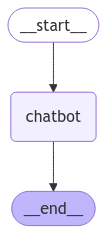

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
display(Image(data=image_bytes))

คุณสามารถเรียกใช้ได้ด้วยเมธอด `stream(`ที่คุ้นเคยซึ่งคุณได้เห็นในบทก่อนหน้า)



In [ ]:
from langchain_core.messages import HumanMessage
input = {"messages": [HumanMessage('hi!')]}
for chunk in graph.stream(input):
  print(chunk)

{'chatbot': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b79e5718-86eb-4c0d-bc35-63d9d562fbbe-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


สังเกตว่าอินพุตไปยังกราฟมีรูปร่างเหมือนกับ State object ที่เราได้กำหนดไว้ก่อนหน้านี้ นั่นคือ เราส่งรายการข้อความในคีย์ messages ของพจนานุกรม

## Adding Memory to StateGraph

LangGraph มีการคงอยู่ในตัว ซึ่งใช้ในลักษณะเดียวกันสำหรับกราฟที่ง่ายที่สุดไปจนถึงกราฟที่ซับซ้อนที่สุด มาดูกันว่าการนำไปใช้กับสถาปัตยกรรมแรกนี้เป็นอย่างไร เราจะรวบรวมกราฟของเราใหม่ โดยแนบเช็คพอยต์ ซึ่งเป็นอะแดปเตอร์จัดเก็บข้อมูลสำหรับ LangGraph LangGraph มาพร้อมกับคลาสพื้นฐานที่ผู้ใช้สามารถสร้างคลาสย่อยเพื่อสร้างอะแดปเตอร์สำหรับฐานข้อมูลที่ชื่นชอบของตนเอง ในขณะที่เขียน LangGraph มาพร้อมกับอะแดปเตอร์หลายตัวที่ดูแลรักษาโดย LangChain:

- **อะแดปเตอร์ในหน่วยความจำ** ซึ่งเราจะใช้สำหรับตัวอย่างของเราที่นี่

- **อะแดปเตอร์ SQLite** โดยใช้ฐานข้อมูลในกระบวนการที่เป็นที่นิยม เหมาะสำหรับแอปพลิเคชันภายในเครื่องและการทดสอบ

- **อะแดปเตอร์ Postgres** ซึ่งได้รับการปรับให้เหมาะสมสำหรับฐานข้อมูลเชิงสัมพันธ์ที่เป็นที่นิยม และเหมาะสำหรับแอปพลิเคชันขนาดใหญ่

นักพัฒนาหลายคนได้เขียนอะแดปเตอร์สำหรับระบบฐานข้อมูลอื่นๆ เช่น Redis หรือ MySQL:

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer=MemorySaver())

สิ่งนี้ส่งคืนอ็อบเจ็กต์ที่สามารถเรียกใช้ได้ด้วยเมธอดเดียวกับที่เราใช้ข้างต้น แต่ตอนนี้ มันจัดเก็บสถานะที่จุดสิ้นสุดของแต่ละขั้นตอน ดังนั้น การเรียกใช้งานทุกครั้งหลังจากครั้งแรกจะไม่เริ่มต้นจากสภาพที่ว่างเปล่า ทุกครั้งที่เรียกใช้กราฟ มันจะเริ่มต้นโดยใช้เช็คพอยต์เพื่อดึงสถานะล่าสุดที่บันทึกไว้ หากมี และรวมอินพุตใหม่เข้ากับสถานะก่อนหน้า จากนั้นจึงดำเนินการโหนดแรก
มาดูความแตกต่างในการใช้งาน:

In [ ]:
thread1 = {"configurable": {"thread_id": "1"}}

result_1 = graph.invoke({"messages": [HumanMessage('hi, my name is Jack!')] },  thread1)
# // { "chatbot": { "messages": [AIMessage("How can I help you, Jack?")] } }

result_2 = graph.invoke({"messages": [HumanMessage('what is my name?')] }, thread1)
# // { "chatbot": { "messages": [AIMessage("Your name is Jack")] } }
result_2

{'messages': [HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='e5cb52ec-6b6c-4739-b375-8003c288c938'),
  AIMessage(content='Hello Jack! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 14, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6fce38ef-7d42-4748-8a69-e6006c18e6d0-0', usage_metadata={'input_tokens': 14, 'output_tokens': 11, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='d2af023b-81

สังเกตวัตถุ thread1 ซึ่งระบุปฏิสัมพันธ์ปัจจุบันว่าเป็นของประวัติการโต้ตอบโดยเฉพาะ ซึ่งใน LangGraph เรียกว่า `threads` เธรดถูกสร้างขึ้นโดยอัตโนมัติเมื่อใช้งานครั้งแรก สตริงใดๆ ก็ตามเป็นตัวระบุที่ถูกต้องสำหรับเธรด (โดยปกติจะใช้ Universally Unique Identifiers [UUIDs]) การมีอยู่ของเธรดช่วยให้คุณบรรลุเป้าหมายสำคัญในแอปพลิเคชัน LLM ของคุณ

**ตอนนี้สามารถใช้งานได้โดยผู้ใช้หลายคนที่มีการสนทนาที่เป็นอิสระซึ่งไม่เคยผสมกัน**

เช่นเดียวกับก่อนหน้านี้ โหนด chatbot ถูกเรียกใช้ครั้งแรกด้วยข้อความเดียว ข้อความที่เราเพิ่งส่งผ่านและส่งคืนข้อความอื่นซึ่งทั้งสองข้อความจะถูกบันทึกไว้ในสถานะ




ครั้งที่สองที่เราเรียกใช้กราฟ บนเธรดเดียวกัน
โหนด `chatbot` ถูกเรียกใช้ด้วยข้อความสามข้อความ ข้อความสองข้อความที่บันทึกไว้จากการเรียกใช้ครั้งแรก และคำถามถัดไปจากผู้ใช้ นี่คือสาระสำคัญของหน่วยความจำ: สถานะก่อนหน้ายังคงอยู่ ซึ่งทำให้สามารถตอบคำถามเกี่ยวกับสิ่งที่พูดมาก่อนหน้านี้ได้ (และทำสิ่งที่น่าสนใจอีกมากมาย ซึ่งเราจะได้เห็นเพิ่มเติมในภายหลัง)

คุณยังสามารถตรวจสอบและอัปเดตสถานะโดยตรงได้ มาดูกันว่าอย่างไร:

In [ ]:
graph.get_state(thread1)

StateSnapshot(values={'messages': [HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='e5cb52ec-6b6c-4739-b375-8003c288c938'), AIMessage(content='Hello Jack! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 14, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6fce38ef-7d42-4748-8a69-e6006c18e6d0-0', usage_metadata={'input_tokens': 14, 'output_tokens': 11, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}

In [ ]:
graph.update_state(thread1, {"messages": [HumanMessage('I like LLMs!')]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efda0cc-5c3f-6a90-800b-aab2b827fb08'}}

In [ ]:
graph.get_state(thread1)

StateSnapshot(values={'messages': [HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='e5cb52ec-6b6c-4739-b375-8003c288c938'), AIMessage(content='Hello Jack! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 14, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6fce38ef-7d42-4748-8a69-e6006c18e6d0-0', usage_metadata={'input_tokens': 14, 'output_tokens': 11, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}

นี่จะเพิ่มข้อความอีกหนึ่งข้อความลงในรายการข้อความในสถานะ เพื่อใช้ในครั้งต่อไปที่คุณเรียกใช้กราฟบนเธรดนี้



# Modifying Chat History
**การแก้ไขประวัติการแชท**

ในหลายกรณี ข้อความประวัติการแชทไม่ได้อยู่ในสถานะหรือรูปแบบที่ดีที่สุดสำหรับการสร้างการตอบกลับที่ถูกต้องจากโมเดล เพื่อแก้ไขปัญหานี้ เราสามารถแก้ไขประวัติการแชทได้สามวิธีหลัก ได้แก่ **การตัดแต่ง การกรอง และการผสานข้อความ**




## Trimming Messages​

**การตัดแต่งข้อความ**

LLM มีหน้าต่างบริบทที่จำกัด กล่าวคือ จำนวนโทเค็นสูงสุดที่สามารถรับเป็นพรอมต์ได้ ดังนั้น พรอมต์สุดท้ายที่ส่งไปยังโมเดลไม่ควรเกินขีดจำกัดนั้น (เฉพาะเจาะจงสำหรับแต่ละโหมด) เนื่องจากโมเดลจะปฏิเสธพรอมต์ที่ยาวเกินไปหรือตัดทอน นอกจากนี้ ข้อมูลพรอมต์ที่มากเกินไปอาจทำให้โมเดลเสียสมาธิและนำไปสู่การหลอน

วิธีแก้ปัญหาที่มีประสิทธิภาพสำหรับปัญหานี้คือการจำกัดจำนวนข้อความที่ดึงมาจากประวัติการแชทและเพิ่มลงในพรอมต์ ในทางปฏิบัติ เราจำเป็นต้องโหลดและจัดเก็บเฉพาะข้อความล่าสุดเท่านั้น มาใช้ประวัติการแชทตัวอย่างที่มีข้อความโหลดไว้ล่วงหน้าบางส่วนกัน

โชคดีที่ LangChain มีตัวช่วย `trim_messages` ในตัว ซึ่งรวมกลยุทธ์ต่างๆ เพื่อตอบสนองความต้องการเหล่านี้ ตัวอย่างเช่น ตัวช่วยตัวตัดแต่งช่วยให้สามารถระบุจำนวนโทเค็นที่เราต้องการเก็บหรือลบออกจากประวัติการแชทได้

นี่คือตัวอย่างที่ดึงโทเค็นล่าสุด `max_tokens` ในรายการข้อความโดยการตั้งค่าพารามิเตอร์กลยุทธ์เป็น `"last"`:

In [ ]:
from langchain_core.messages import SystemMessage, trim_messages, AIMessage
from langchain_openai import ChatOpenAI

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4o"),
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="what's 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="what's 2 + 2", additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

**หมายเหตุต่อไปนี้:**
- พารามิเตอร์ `strategy` ควบคุมว่าจะเริ่มต้นจากจุดเริ่มต้นหรือจุดสิ้นสุดของรายการ โดยปกติ คุณจะต้องการให้ความสำคัญกับข้อความล่าสุดและตัดข้อความที่เก่ากว่าออกหากไม่พอดี กล่าวคือ เริ่มต้นจากจุดสิ้นสุดของรายการ สำหรับพฤติกรรมนี้ เลือกค่า last ตัวเลือกอื่นที่พร้อมใช้งานคือ first ซึ่งจะให้ความสำคัญกับข้อความที่เก่าที่สุดและตัดข้อความที่ใหม่กว่าออกหากไม่พอดี
- `token_counter` คือ LLM หรือโมเดลแชท ซึ่งจะใช้ในการนับโทเค็นโดยใช้ตัวโทเคไนเซอร์ที่เหมาะสมกับโมเดลนั้น
เราสามารถเพิ่มพารามิเตอร์ `include_system=True` เพื่อให้แน่ใจว่าตัวตัดแต่งจะเก็บข้อความระบบไว้
- พารามิเตอร์ `allow_partial` กำหนดว่าจะตัดเนื้อหาของข้อความสุดท้ายเพื่อให้พอดีกับขีดจำกัดหรือไม่ ในตัวอย่างของเรา เราตั้งค่านี้เป็น `false` ซึ่งจะลบข้อความที่ส่งผลให้เกินขีดจำกัดออกทั้งหมด
- พารามิเตอร์ `start_on="human"` ช่วยให้แน่ใจว่าเราจะไม่ลบ AIMessage (นั่นคือ การตอบกลับจากโมเดล) โดยไม่ลบ `HumanMessage` ที่สอดคล้องกัน (คำถามสำหรับการตอบกลับนั้น)

## Filtering Messages
**การกรองข้อความ**
เมื่อรายการข้อความประวัติการแชทเติบโตขึ้น อาจมีการใช้ประเภท เชนย่อย และโมเดลที่หลากหลายมากขึ้น ตัวช่วย filter_messages ของ LangChain ช่วยให้การกรองข้อความประวัติการแชทตามประเภท ID หรือชื่อทำได้ง่ายขึ้น

นี่คือตัวอย่างที่เรากรองสำหรับข้อความของมนุษย์:



In [ ]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    filter_messages,
)

messages = [
    SystemMessage("you are a good assistant", id="1"),
    HumanMessage("example input", id="2", name="example_user"),
    AIMessage("example output", id="3", name="example_assistant"),
    HumanMessage("real input", id="4", name="bob"),
    AIMessage("real output", id="5", name="alice"),
]

filter_messages(messages, include_types="human")

[HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'),
 HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4')]

มาลองดูตัวอย่างอื่นที่เรากรองเพื่อไม่รวมผู้ใช้และ ID และรวมประเภทข้อความ:



In [ ]:
filter_messages(messages, exclude_names=["example_user", "example_assistant"])

"""
[SystemMessage(content='you are a good assistant', id='1'),
HumanMessage(content='real input', name='bob', id='4'),
AIMessage(content='real output', name='alice', id='5')]
"""

filter_messages(messages, include_types=[HumanMessage, AIMessage], exclude_ids=["3"])

"""
[HumanMessage(content='example input', name='example_user', id='2'),
 HumanMessage(content='real input', name='bob', id='4'),
 AIMessage(content='real output', name='alice', id='5')]
"""

"\n[HumanMessage(content='example input', name='example_user', id='2'),\n HumanMessage(content='real input', name='bob', id='4'),\n AIMessage(content='real output', name='alice', id='5')]\n"

ตัวช่วย `filter_messages` ยังสามารถใช้ได้ทั้งแบบบอกและแบบประกาศ ซึ่งทำให้การประสมประสานกับส่วนประกอบอื่นๆ ในเชนทำได้ง่าย:



In [ ]:
model = ChatOpenAI()

filter_ = filter_messages(exclude_names=["example_user", "example_assistant"])

chain = filter_ | model


## Merging Consecutive Messages

**การรวมข้อความต่อเนื่อง**

มีบางโมเดลที่ไม่รองรับอินพุต รวมถึงข้อความต่อเนื่องประเภทเดียวกัน ตัวอย่างเช่น โมเดลแชท Anthropic ยูทิลิตี้ merge_message_runs ของ LangChain ช่วยให้การรวมข้อความต่อเนื่องประเภทเดียวกันทำได้ง่าย:



In [ ]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    merge_message_runs,
)

messages = [
    SystemMessage("you're a good assistant."),
    SystemMessage("you always respond with a joke."),
    HumanMessage([{"type": "text", "text": "i wonder why it's calledlangchain"}]),
    HumanMessage("and who is harrison chasing anyway"),
    AIMessage('Well, I guess they thought "WordRope" and "SentenceString" just didn\'t have the same ring to it!'),
    AIMessage("Why, he's probably chasing after the last cup of coffee in the office!"),
]

merge_message_runs(messages)

[SystemMessage(content="you're a good assistant.\nyou always respond with a joke.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'type': 'text', 'text': "i wonder why it's calledlangchain"}, 'and who is harrison chasing anyway'], additional_kwargs={}, response_metadata={}),
 AIMessage(content='Well, I guess they thought "WordRope" and "SentenceString" just didn\'t have the same ring to it!\nWhy, he\'s probably chasing after the last cup of coffee in the office!', additional_kwargs={}, response_metadata={})]

สังเกตว่าหากเนื้อหาของข้อความใดข้อความหนึ่งที่จะรวมกันเป็นรายการของบล็อกเนื้อหา ข้อความที่รวมกันจะมีรายการของบล็อกเนื้อหา และหากข้อความทั้งสองที่จะรวมกันมีเนื้อหาเป็นสตริง สตริงเหล่านั้นจะถูกต่อกันด้วยอักขระใหม่บรรทัด

ตัวช่วย `merge_message_runs` สามารถใช้ได้ทั้งแบบบอกและแบบประกาศ ซึ่งทำให้การประสมประสานกับส่วนประกอบอื่นๆ ในเชนทำได้ง่าย:

In [ ]:
model = ChatOpenAI()
merger = merge_message_runs()
chain = merger | model

# Summary

**สรุป**

บทนี้กล่าวถึงพื้นฐานของการสร้างระบบหน่วยความจำอย่างง่ายที่ช่วยให้แชทบอท AI ของคุณสามารถจำการสนทนากับผู้ใช้ได้ เราได้กล่าวถึงวิธีการอัตโนมัติในการจัดเก็บและอัปเดตประวัติการแชทโดยใช้ LangGraph เพื่อให้ง่ายขึ้น นอกจากนี้ เรายังได้กล่าวถึงความสำคัญของการแก้ไขประวัติการแชทและสำรวจกลยุทธ์ต่างๆ ในการตัดแต่ง กรอง และสรุปข้อความแชท

**ใน บทที่ 5 คุณจะเริ่มเรียนรู้วิธีการเปิดใช้งานแชทบอท AI ของคุณให้ทำมากกว่าการแชทกลับ เช่น การตัดสินใจ เลือกการกระทำ และสะท้อนการพูดในอดีตของตนเอง**